In [1]:
%matplotlib inline
import numpy as np
import os
from ctypes import CDLL, c_float, Structure
pi = np.pi

#change current working directory to directory with code:
#os.chdir("./DriveBreakControl")

# Simulation
Now simulate the control scheme using the forward Euler method.
$$v[k+1] = v[k] + dt\frac{\mathrm{d}v}{\mathrm{d}t} = v[k] +dt(-\gamma_{1m} v[k] + \gamma_{2m} u[k])$$

While recording the position is not required by our model, doing so means we can simulate the discretization effect of the encoder.
$$position[k+1] = position[k] + dt * v$$

## C bindings
In this code we will call the already-created C++ library so we can verify its correct operation. We load this file using ctypes. This only works on Linux, not Windows.

To compile the library: gcc -shared -o control_lib.so -fPIC controller_estimator.cpp

Tutorials: https://realpython.com/python-bindings-overview/#ctypes and https://www.csestack.org/calling-c-functions-from-python/

In [2]:
c_lib_name = "./DriveBreakControl/control_lib.so"

#Load the C library
controller = CDLL(c_lib_name)
controller.get_speed()

#Replica of float_pair structure
class float_pair(Structure):
    _fields_ = [("first", c_float), ("second", c_float)]

#Now break out functions for easy calling:
HallEncoderInterrupt = controller.HallEncoderInterrupt
HallEncoderInterrupt.argtypes = []
HallEncoderInterrupt.restype = None

estimate_vel = controller.estimate_vel
estimate_vel.argtypes = [c_float, c_float, c_float]
estimate_vel.restype = c_float

get_speed = controller.get_speed
get_speed.argtypes = []
get_speed.restype = c_float

gen_control_voltage_brake_force = controller.gen_control_voltage_brake_force
gen_control_voltage_brake_force.argtypes = [c_float, c_float, c_float]
gen_control_voltage_brake_force.restype = float_pair

get_curr_target_speed = controller.get_curr_target_speed
get_curr_target_speed.argtypes = []
get_curr_target_speed.restype = c_float

get_error_integral = controller.get_error_integral
get_error_integral.argtypes = []
get_error_integral.restype = c_float

## True car parameters
These are what the car parameters REALLY are. This lets us simulate model imperfections. Anything starting with 'true_' indicates a parameter that is different in real life than what we designed the controller to.

In [3]:
#Which file to use: software_commanded_vel.csv or sinusoidal_vels.csv
velocity_profile_file_name = "software_commanded_vel.csv"

#True parameters:
true_m = 150  #150 design
true_d = 20   #10 design
true_Gr = 64/22 #Gear ratio
true_rw = 0.27/2 #Tire radius
true_wheel_circumference = 2*pi*true_rw

#encoder ticks per revolution
magnets_on_shaft = 24
magnets_per_m = magnets_on_shaft/true_wheel_circumference

#true motor specs
true_R = 0.02  #0.01 ohms is spec sheet; we measured 0.032 to 0.046 ohms. Design is 0.035 ohms
true_Kv = 0.0132 * 60/(2*pi)
true_Kt = 0.1260  #0.1260 design

#Calculate simulation equation parameters:
#v_dot = -gamma_speed * v + gamma_volt * V - gamma_brake * F_b
true_gamma_speed = true_Kt*true_Kv*true_Gr**2/(true_rw**2 * true_R*true_m) + true_d/true_m
true_gamma_volt = true_Gr*true_Kt/(true_rw * true_R*true_m)
true_gamma_brake = 1/true_m

#Back-EMF and motor current:
true_V_back_emf_per_speed = true_Gr*true_Kv/true_rw
true_motor_force_per_amp = true_Gr*true_Kt/true_rw

#Current sensor non-idealities. Setting both to 0 makes current sensor ideal
current_sensor_bias_A = 2    #Current sensor offset in amps. Can be + or -
current_sensor_noise_std_dev = 2  #Standard deviation of additive Gaussian noise in current sensor

#Calculate true controller limits:
true_max_motor_amps = 300    #300 design
true_max_battery_amps = 200
true_V_batt = 48    #48V designed

true_decel_max = 10   #Limit on braking deceleration

In [4]:
#Read in the CSV of commanded velocities
import csv
ns_per_sec = 1e9
with open(velocity_profile_file_name) as velocity_csv:  
    velocity_reader = csv.reader(velocity_csv, delimiter=',')
    next(velocity_reader)   #Skip first line, the headers
    software_velocity_times_commands = np.asarray([(int(line[0]), float(line[1])) for line in velocity_reader])
software_velocity_times_commands[:,0] /= ns_per_sec     #Convert times from ns to seconds
software_velocity_times_commands[:,0] -= software_velocity_times_commands[0,0]   #Make time start at 0

print(software_velocity_times_commands)

#Remember the last time and index we were ordered to fe
last_gotten_idx = 0
last_gotten_time = 0
def get_software_vel(time):
    '''
    Gets the last command software sent at the given time.
    Remembers the index of the last time it was called for increased efficiency in case time is monotonically increasing
    '''
    global last_gotten_idx
    global last_gotten_time
    
    if time > last_gotten_time:
        idx = last_gotten_idx
    else:
        idx = 0

    while software_velocity_times_commands[idx + 1, 0] < time:
        idx += 1
    
    last_gotten_idx = idx
    last_gotten_time = time
    return software_velocity_times_commands[idx, 1]

print("First commanded speed:", get_software_vel(0))

[[0.00000000e+00 4.00374116e-01]
 [4.00000000e-02 8.00374116e-01]
 [8.90000000e-02 1.10037412e+00]
 ...
 [5.55270000e+01 1.12442532e+01]
 [5.55570000e+01 0.00000000e+00]
 [6.55570000e+01 0.00000000e+00]]
First commanded speed: 0.400374116174075


In [5]:
#Define simulation physics parameters not already defined above
min_voltage = 0

start_velocity = 0

simulate_encoder_effect = True  #Simulate discretizing effect of encoder or not.

dt = 5e-5  #Timestep
end_time = software_velocity_times_commands[-1,0]

simulate_brake_update_rate = True  #Simulate us sending new force commands to the brakes at a finite rate
time_between_brake_updates = 1/20

#Define controller parameters (so we can tweak them)
controller_loop_time = 5e-3   #How frequently (in s) the controller runs

#Define data logging arrays
times, dt = np.linspace(0, end_time, num = round(end_time/dt), retstep=True)  #array of times
vel_kart_arr = np.zeros(len(times))  #actual kart velocity
estimated_vel_arr = np.zeros(len(times))
filtered_vel_arr = np.zeros(len(times)) #Result of our trapezoidal approximation to software's commands
software_command_velocities_at_timestep_arr = np.zeros(len(times))  #We have Software's velocities at random times they chose - map into our array so we can plot
voltage_cmd_arr = np.zeros(len(times)) #The voltage command
voltage_realized_arr = np.zeros(len(times))  #The real voltage sent to the motor
brake_realized_arr = np.zeros(len(times))    #The realized braking force
motor_current_arr = np.zeros(len(times))     #The motor current
brake_cmd_arr = np.zeros(len(times)) #The brake command
error_integral_arr = np.zeros(len(times))  #The voltage commanded by the error integral


In [6]:
def get_true_voltage_current(true_speed, commanded_voltage):
    '''
    Calculates the effects of the controller's current limit on the voltage output by the controller, as described above
    '''
    V_back_emf = true_speed * true_V_back_emf_per_speed
    
    if V_back_emf > 0:
        true_I_max = min(true_max_motor_amps, true_V_batt*true_max_battery_amps/V_back_emf)
    else:
        true_I_max = true_max_motor_amps
    
    #Check voltage won't cause controller to exceed current limit
    if commanded_voltage > V_back_emf + true_R*true_I_max:
        commanded_voltage = V_back_emf + true_R*true_I_max
    elif commanded_voltage < V_back_emf:
        commanded_voltage = V_back_emf
    
    #Now check controller voltage limit
    if commanded_voltage > true_V_batt:
        commanded_voltage = true_V_batt
    elif commanded_voltage < 0:
        commanded_voltage = 0

    true_motor_current = (commanded_voltage - V_back_emf)/true_R  
    return commanded_voltage, true_motor_current

def get_true_braking_force(true_vel, braking_force):
    #Brakes cannot accelerate car or slow faster than decel_max
    
    if braking_force < 0:
        braking_force = 0
    elif braking_force > true_decel_max*true_m:
        braking_force = true_decel_max*true_m
    
    #Check if we are going in reverse
    if true_vel == 0:
        braking_force = 0
    elif true_vel < 0:
        braking_force = -braking_force

    return braking_force

def get_current_sensor_reading(real_motor_current):
    return real_motor_current + np.random.normal(current_sensor_bias_A, current_sensor_noise_std_dev)

#Now write the simulation code
command_voltage = 0
sent_brake_command = 0
command_brakes = 0
last_brake_cmd_send_time = 0
last_controller_execution = 0
last_encoder_speed_calc_time = 0
car_true_vel = start_velocity
car_true_position = 0
num_encoder_ticks = 0
last_encoder_read_position = 0
encoder_est_speed = 0

for i in range(len(times)):
    time = times[i]
    
    #Find software's current vel
    software_vel_cmd = get_software_vel(time)
    
    #Execute the controller
    if time - last_controller_execution > controller_loop_time:
        timestep = time - last_controller_execution
        
        #estimate speed
        current_reading = get_current_sensor_reading(true_motor_current)
        encoder_est_speed = estimate_vel(timestep, current_reading, command_brakes)
        
        #Get commands
        command_voltage_brakes = gen_control_voltage_brake_force(timestep, encoder_est_speed, software_vel_cmd)
        command_voltage = command_voltage_brakes.first
        command_brakes = command_voltage_brakes.second
        
        if simulate_brake_update_rate:
            if time - last_brake_cmd_send_time > time_between_brake_updates:
                sent_brake_command = command_brakes
        else:
            sent_brake_command = command_brakes
        
        last_controller_execution = time
    
    #Bound the control signals
    true_voltage, true_motor_current = get_true_voltage_current(car_true_vel, command_voltage)
    true_brake_force = get_true_braking_force(car_true_vel, sent_brake_command)
    
    #Car physics:
    car_true_position += dt*car_true_vel
    car_true_vel += dt*(-true_gamma_speed*car_true_vel + true_gamma_volt*true_voltage - true_gamma_brake*true_brake_force)
    
    #encoder callback interrupt fires
    if num_encoder_ticks/magnets_per_m < car_true_position:
        num_encoder_ticks += 1
        #fire interrupt
        HallEncoderInterrupt()
    
    #Now do the logs
    vel_kart_arr[i] = car_true_vel
    estimated_vel_arr[i] = get_speed()
    filtered_vel_arr[i] = get_curr_target_speed()
    software_command_velocities_at_timestep_arr[i] = software_vel_cmd
    voltage_cmd_arr[i] = command_voltage
    brake_cmd_arr[i] = command_brakes
    voltage_realized_arr[i] = true_voltage
    brake_realized_arr[i] = true_brake_force
    motor_current_arr[i] = true_motor_current
    error_integral_arr[i] = get_error_integral()
    
    
    
    
    

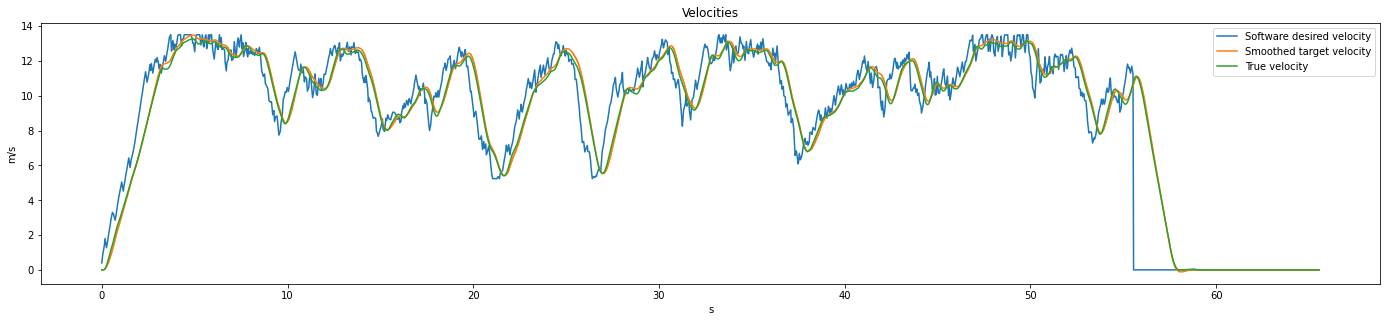

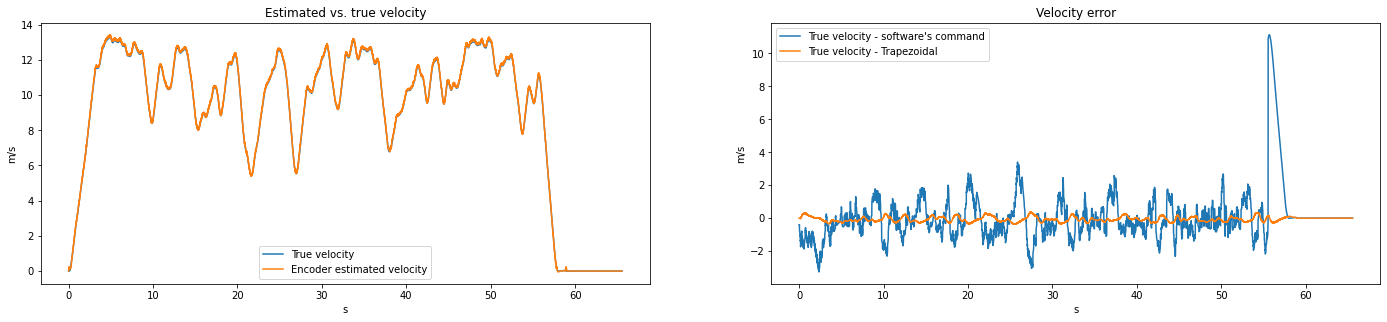

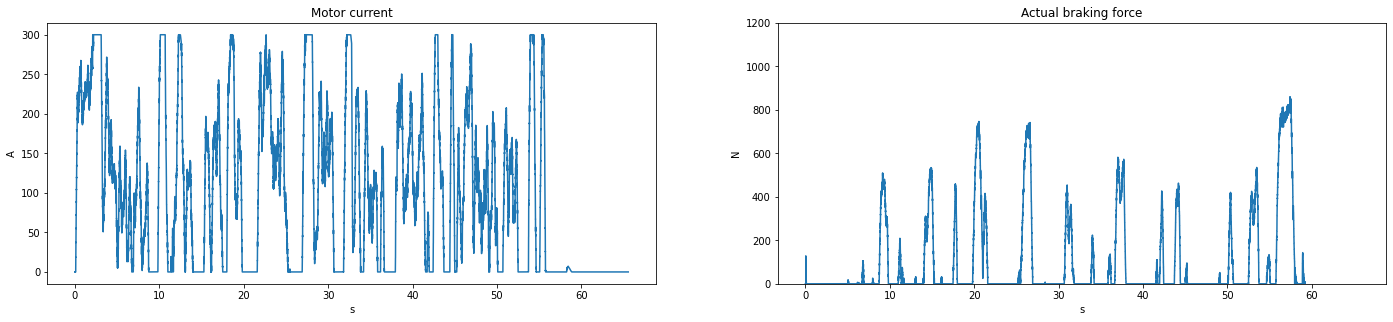

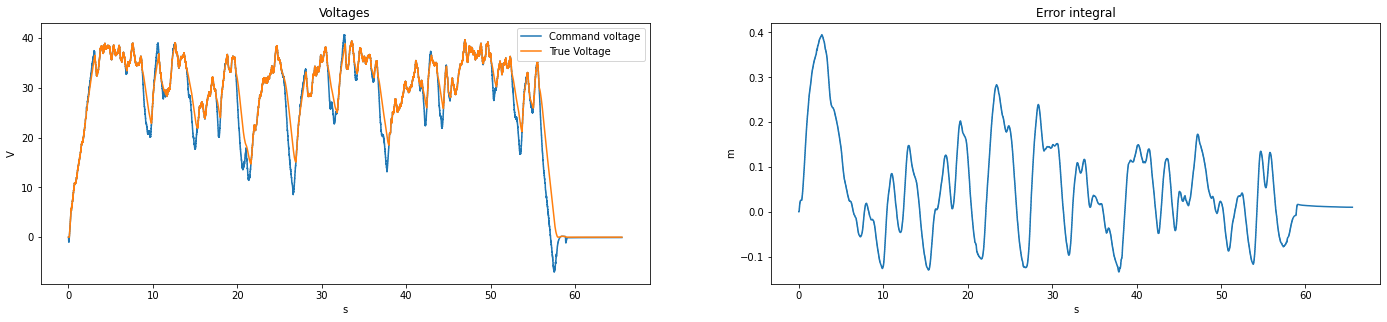

RMS current value: 150.11077613607569
Average brake power dissipation: 760.8712745837191
Fraction of time brakes and motor on simultaneously: 0.0117425


In [7]:
#Plots!
import matplotlib.pyplot as plt
plot_resolution = 10    #Only plot one of every [this] values to accelerate plotting

times_to_plot = times[::plot_resolution]
true_velocities_to_plot = vel_kart_arr[::plot_resolution]

plt.figure(1, figsize=(24, 4.8))
plt.plot(software_velocity_times_commands[:,0], software_velocity_times_commands[:,1])
plt.plot(times_to_plot, filtered_vel_arr[::plot_resolution])
plt.plot(times_to_plot, true_velocities_to_plot)

plt.title("Velocities")
plt.ylabel("m/s")
plt.xlabel("s")
plt.legend(['Software desired velocity', 'Smoothed target velocity', 'True velocity'])

plt.show()

plt.figure(2, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, true_velocities_to_plot)
plt.plot(times_to_plot, estimated_vel_arr[::plot_resolution])

plt.title("Estimated vs. true velocity")
plt.legend(['True velocity', "Encoder estimated velocity"])
plt.ylabel("m/s")
plt.xlabel("s")

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, true_velocities_to_plot - software_command_velocities_at_timestep_arr[::plot_resolution])
plt.plot(times_to_plot, true_velocities_to_plot - filtered_vel_arr[::plot_resolution])

plt.title("Velocity error")
plt.legend(["True velocity - software's command", 'True velocity - Trapezoidal'])
plt.ylabel("m/s")
plt.xlabel("s")

plt.show()

plt.figure(3, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, motor_current_arr[::plot_resolution])
plt.title("Motor current")
plt.ylabel("A")
plt.xlabel("s")

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, brake_realized_arr[::plot_resolution])
plt.ylim(0, 1200)
plt.title("Actual braking force")
plt.ylabel("N")
plt.xlabel("s")
plt.show()


plt.figure(4, figsize=(24, 4.8))
plt.subplot(1, 2, 1)
plt.plot(times_to_plot, voltage_cmd_arr[::plot_resolution])
plt.plot(times_to_plot, voltage_realized_arr[::plot_resolution])

plt.title("Voltages")
plt.ylabel("V")
plt.xlabel("s")
plt.legend(['Command voltage', 'True Voltage'])

plt.subplot(1, 2, 2)
plt.plot(times_to_plot, error_integral_arr[::plot_resolution])

plt.title("Error integral")
plt.ylabel("m")
plt.xlabel("s")
plt.show()

#Print out some stats
stat_start_time = 10
stat_end_time = 50
off_threshold = 1
stat_start_idx = int(stat_start_time/dt)
stat_end_idx = int(stat_end_time/dt)

rms_current = np.sqrt(np.mean(motor_current_arr[stat_start_idx:stat_end_idx]**2))
avg_brake_power = np.mean(vel_kart_arr[stat_start_idx:stat_end_idx]*brake_realized_arr[stat_start_idx:stat_end_idx])
print("RMS current value:", rms_current)
print("Average brake power dissipation:", avg_brake_power)

brakes_motor_simultaneous = np.logical_and(motor_current_arr[stat_start_idx:stat_end_idx]>off_threshold, brake_realized_arr[stat_start_idx:stat_end_idx]>off_threshold)
print("Fraction of time brakes and motor on simultaneously:", np.mean(brakes_motor_simultaneous))